In [1]:

import statsmodels.api as sm
import pandas as pd
import numpy as np
from sklearn.model_selection import StratifiedGroupKFold


import numpy as np
import pandas as pd
import sys

from polyssifier import poly

import logging 

import scipy.sparse as sp
import scipy.io
from scipy.stats import zscore
from scipy.signal import detrend

from scipy.sparse.linalg import eigs
from gunfolds.utils import graphkit as gk
from gunfolds.conversions import graph2adj

import matplotlib.pyplot as plt

from sklearn.preprocessing import MinMaxScaler
from sklearn.utils import check_random_state
from sklearn.impute import SimpleImputer


from sklearn.neural_network import MLPClassifier
from sklearn.metrics import roc_auc_score

In [2]:

def check_matrix_powers(W, A, powers, threshold):
    for n in powers:
        W_n = np.linalg.matrix_power(W, n)
        non_zero_indices = np.nonzero(W_n)
        if (np.abs(W_n[non_zero_indices]) < threshold).any():
            return False
    return True


def create_stable_weighted_matrix(
    A,
    threshold=0.1,
    powers=[1, 2, 3, 4],
    max_attempts=1000,
    damping_factor=0.99,
    random_state=None,
):
    np.random.seed(
        random_state
    )  # Set random seed for reproducibility if provided
    attempts = 0

    while attempts < max_attempts:
        # Generate a random matrix with the same sparsity pattern as A
        random_weights = np.random.randn(*A.shape)
        weighted_matrix = A * random_weights

        # Convert to sparse format for efficient eigenvalue computation
        weighted_sparse = sp.csr_matrix(weighted_matrix)

        # Compute the largest eigenvalue in magnitude
        eigenvalues, _ = eigs(weighted_sparse, k=1, which="LM")
        max_eigenvalue = np.abs(eigenvalues[0])

        # Scale the matrix so that the spectral radius is slightly less than 1
        if max_eigenvalue > 0:
            weighted_matrix *= damping_factor / max_eigenvalue
            # Check if the powers of the matrix preserve the threshold for non-zero entries of A
            if check_matrix_powers(weighted_matrix, A, powers, threshold):
                return weighted_matrix

        attempts += 1

    raise ValueError(
        f"Unable to create a matrix satisfying the condition after {max_attempts} attempts."
    )


def drawsamplesLG(A, nstd, samples):
    n = A.shape[0]
    data = np.zeros([n, samples])
    data[:, 0] = nstd * np.random.randn(A.shape[0])
    for i in range(1, samples):
        data[:, i] = A @ data[:, i - 1] + nstd * np.random.randn(A.shape[0])
    return data


def genData(A, rate=2, burnin=100, ssize=5000, nstd=0.1):
    Agt = A.copy()
    data = drawsamplesLG(Agt, samples=burnin + (ssize * rate), nstd=nstd)
    data = data[:, burnin:]
    return data[:, ::rate]

In [3]:
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')


#Step 0: Iterate through values for nstd, burnin, noise_svar
nstd = 1.0
burn = 100
threshold = 0.0001

NOISE_SIZE = 2961*2
NUM_SUBS = 10
subjects = ['20150210', '20150417', '20150428', '20151110', '20151127', 
            '20150410', '20150421', '20151030', '20151117', '20151204']

num_graphs = 1
num_noise = 2
n_folds = 4
n_threads= 12

graph_ix = 1002
graph_dir = '/data/users2/jwardell1/nshor_docker/examples/oulu-project/OULU/g4.pkl'
g = np.load(graph_dir, allow_pickle=True)
A = graph2adj(g)
u_rate = 1
logging.info(f'\t\t\t\tGraph Number {graph_ix} of {num_graphs}')

#SNR = 1

SNRs = [0.5, 0.6, 0.7, 0.8, 0.9, 1.0, 1.5, 2.0]

2024-05-09 21:27:36,089 - INFO - 				Graph Number 1002 of 1


In [5]:
noise_ix = 0
SNR = SNRs[5]
scalar = 10**(SNR/-2)
logging.info(f'\t\t\t\tSNR {SNR}')
logging.info(f'\t\t\t\tscalar {scalar}')

2024-05-09 21:27:49,427 - INFO - 				SNR 1.0
2024-05-09 21:27:49,430 - INFO - 				scalar 0.31622776601683794


In [6]:
num_converged = 0
converged_subjects = []
noises = dict()
while num_converged < NUM_SUBS:
    for subject in subjects:
        if subject in converged_subjects:
            continue

        try:
            W = create_stable_weighted_matrix(A, threshold=threshold, powers=[2])
            var_noise = genData(W, rate=u_rate, burnin=burn, ssize=NOISE_SIZE, nstd=nstd)
            var_noise = zscore(var_noise, axis=1)
            noises[subject] = var_noise * scalar
            num_converged += 1
            converged_subjects.append(subject)

        except Exception as e:
            print(e)
            logging.info(f'num converged: {num_converged}')
            
noises

2024-05-09 21:28:05,286 - INFO - num converged: 2


ARPACK error -1: No convergence (531 iterations, 0/1 eigenvectors converged) [ARPACK error -14: DNAUPD  did not find any eigenvalues to sufficient accuracy.]


2024-05-09 21:28:06,049 - INFO - num converged: 3


ARPACK error -1: No convergence (531 iterations, 0/1 eigenvectors converged) [ARPACK error -14: DNAUPD  did not find any eigenvalues to sufficient accuracy.]


2024-05-09 21:28:06,635 - INFO - num converged: 3


ARPACK error -1: No convergence (531 iterations, 0/1 eigenvectors converged) [ARPACK error -14: DNAUPD  did not find any eigenvalues to sufficient accuracy.]


2024-05-09 21:28:07,403 - INFO - num converged: 4


ARPACK error -1: No convergence (531 iterations, 0/1 eigenvectors converged) [ARPACK error -14: DNAUPD  did not find any eigenvalues to sufficient accuracy.]


2024-05-09 21:28:08,016 - INFO - num converged: 4


ARPACK error -1: No convergence (531 iterations, 0/1 eigenvectors converged) [ARPACK error -14: DNAUPD  did not find any eigenvalues to sufficient accuracy.]


2024-05-09 21:28:08,780 - INFO - num converged: 5


ARPACK error -1: No convergence (531 iterations, 0/1 eigenvectors converged) [ARPACK error -14: DNAUPD  did not find any eigenvalues to sufficient accuracy.]


2024-05-09 21:28:09,571 - INFO - num converged: 7


ARPACK error -1: No convergence (531 iterations, 0/1 eigenvectors converged) [ARPACK error -14: DNAUPD  did not find any eigenvalues to sufficient accuracy.]


2024-05-09 21:28:10,308 - INFO - num converged: 8


ARPACK error -1: No convergence (531 iterations, 0/1 eigenvectors converged) [ARPACK error -14: DNAUPD  did not find any eigenvalues to sufficient accuracy.]


2024-05-09 21:28:11,065 - INFO - num converged: 9


ARPACK error -1: No convergence (531 iterations, 0/1 eigenvectors converged) [ARPACK error -14: DNAUPD  did not find any eigenvalues to sufficient accuracy.]


2024-05-09 21:28:11,681 - INFO - num converged: 9


ARPACK error -1: No convergence (531 iterations, 0/1 eigenvectors converged) [ARPACK error -14: DNAUPD  did not find any eigenvalues to sufficient accuracy.]


{'20150210': array([[ 0.11376087, -0.24986758, -0.47230226, ...,  0.09750939,
          0.00306605,  0.16299507],
        [ 0.24575041,  0.50912519, -0.08685974, ..., -0.00325556,
         -0.15543645,  0.27035353],
        [ 0.48063262, -0.07891014,  0.00372321, ..., -0.13217634,
          0.31082238, -0.22028131],
        ...,
        [ 0.39743096,  0.50521126, -0.18917426, ..., -0.02238904,
         -0.17497831,  0.11362287],
        [-0.53559878,  0.08464382,  0.09471631, ...,  0.2704185 ,
         -0.26695136,  0.04434738],
        [-0.02502776, -0.09066717,  0.24673318, ...,  0.2114513 ,
         -0.0948739 , -0.00183845]]),
 '20150417': array([[ 0.16844368,  0.03441405,  0.38241131, ...,  0.23907197,
          0.44523784,  0.09453514],
        [-0.03437912, -0.02194055,  0.04510345, ..., -0.26722484,
          0.01765679,  0.17707606],
        [ 0.08079136,  0.37395002,  0.22672716, ..., -0.04592495,
         -0.03618766, -0.06726327],
        ...,
        [-0.03281935,  0.56686

In [98]:
all_data = []

with open('/data/users2/jwardell1/undersampling-project/OULU/txt-files/allsubs_TCs.txt', 'r') as tc_data:
    lines = tc_data.readlines()

for i in range(0, len(lines), 2):
    subject = subjects[i//2]
    logging.info(f'loading TC for subject {subject}')
    filepath_sr1 = lines[i].strip()
    filepath_sr2 = lines[i+1].strip()
    try:
        sr1 = scipy.io.loadmat(filepath_sr1)['TCMax']
        sr2 = scipy.io.loadmat(filepath_sr2)['TCMax']
    
    except:
        continue

    if sr1.shape[0] != 53:
        sr1 = sr1.T

    if sr2.shape[0] != 53:
        sr2 = sr2.T
    
    if sr1.shape[1] < sr2.shape[1]:
        tr100_tc = sr2
        tr2150_tc = sr1
    else:
        tr100_tc = sr1
        tr2150_tc = sr2

    logging.info(f'subject {subject} tr100_tc.shape - {tr100_tc.shape}')
    logging.info(f'subject {subject} tr2150_tc.shape - {tr2150_tc.shape}')

    tr100_tc_zs = zscore(tr100_tc, axis=1)
    tr2150_tc_zs = zscore(tr2150_tc, axis=1)

    tr100_tc_zs_dt = detrend(tr100_tc_zs, axis=1)
    tr2150_tc_zs_dt = detrend(tr2150_tc_zs, axis=1)

    noise_tr100 = noises[subject][:,::2]#/2 #####DEBUG TODO: check later
    noise_tr2150 = noises[subject][:,::33]

    tr100_tc_zs_dt_noise = tr100_tc_zs_dt+noise_tr100
    tr2150_tc_zs_dt_noise = tr2150_tc_zs_dt+noise_tr2150

    all_data.append({'Subject_ID'             : str(subject), 
                    'VAR_Noise'               : noises[subject], 
                    'TR100_Noise'             : noise_tr100, 
                    'TR2150_Noise'            : noise_tr2150, 
                    'TR100_Timecourse'        : tr100_tc_zs_dt, 
                    'TR2150_Timecourse'       : tr2150_tc_zs_dt, 
                    'TR100_Timecourse_Noise'  : tr100_tc_zs_dt_noise, 
                    'TR2150_Timecourse_Noise' : tr2150_tc_zs_dt_noise})
    
data_df = pd.DataFrame(all_data)

data_df

2024-05-09 20:16:55,370 - INFO - loading TC for subject 20150210
2024-05-09 20:16:55,404 - INFO - subject 20150210 tr100_tc.shape - (53, 2961)
2024-05-09 20:16:55,405 - INFO - subject 20150210 tr2150_tc.shape - (53, 180)
2024-05-09 20:16:55,529 - INFO - loading TC for subject 20150417
2024-05-09 20:16:55,570 - INFO - subject 20150417 tr100_tc.shape - (53, 2961)
2024-05-09 20:16:55,573 - INFO - subject 20150417 tr2150_tc.shape - (53, 180)
2024-05-09 20:16:55,710 - INFO - loading TC for subject 20150428
2024-05-09 20:16:55,750 - INFO - subject 20150428 tr100_tc.shape - (53, 2961)
2024-05-09 20:16:55,751 - INFO - subject 20150428 tr2150_tc.shape - (53, 180)
2024-05-09 20:16:55,908 - INFO - loading TC for subject 20151110
2024-05-09 20:16:55,936 - INFO - subject 20151110 tr100_tc.shape - (53, 2961)
2024-05-09 20:16:55,937 - INFO - subject 20151110 tr2150_tc.shape - (53, 180)
2024-05-09 20:16:56,061 - INFO - loading TC for subject 20151127
2024-05-09 20:16:56,104 - INFO - subject 20151127 t

,Subject_ID,VAR_Noise,TR100_Noise,TR2150_Noise,TR100_Timecourse,TR2150_Timecourse,TR100_Timecourse_Noise,TR2150_Timecourse_Noise
0,20150210,"[[-0.15981092867594995, -0.4833886108919966, -...","[[-0.07990546433797498, -0.19742480056063683, ...","[[-0.15981092867594995, 0.6251504959096559, 0....","[[-0.04384497970934796, -1.1089141040646802, -...","[[0.6886887100527853, -0.49795380956891466, -0...","[[-0.12375044404732294, -1.306338904625317, -0...","[[0.5288777813768354, 0.12719668634074122, -0...."
1,20150417,"[[0.19506213252198573, 0.0034443434631830482, ...","[[0.09753106626099287, -0.1603951412167386, 0....","[[0.19506213252198573, 0.3481412676614844, 0.8...","[[-0.1607202925005835, -0.8571620023770684, -0...","[[-3.4277492842723736, -1.2679357539105018, 0....","[[-0.06318922623959064, -1.0175571435938071, -...","[[-3.2326871517503877, -0.9197944862490175, 1...."
2,20150428,"[[-0.39526105069953915, 0.548164117362697, 0.5...","[[-0.19763052534976958, 0.2926151078094138, -0...","[[-0.39526105069953915, 0.19201400818017914, 0...","[[-0.23731891151139628, -0.9356178523703165, -...","[[-6.277579290892412, -3.1454145826612776, -1....","[[-0.43494943686116583, -0.6430027445609027, -...","[[-6.672840341591951, -2.9534005744810985, -1...."
3,20151110,"[[-0.20349820308022024, -0.25183435222029593, ...","[[-0.10174910154011012, 0.2562332652942423, -0...","[[-0.20349820308022024, -0.10532916725159772, ...","[[0.041609048840367646, -1.0327117238148629, -...","[[-1.7756207977992478, -0.5414674717187071, 0....","[[-0.06014005269974247, -0.7764784585206206, -...","[[-1.979119000879468, -0.6467966389703048, 0.3..."
4,20151127,"[[-0.759728142765507, -0.06393054540478073, 0....","[[-0.3798640713827535, 0.06290308396398869, 0....","[[-0.759728142765507, 0.1636262452048647, 0.31...","[[0.4715334566403786, 0.8085277405442564, 0.57...","[[-0.5468216084070829, 0.8562373936238572, 1.6...","[[0.09166938525762508, 0.871430824508245, 0.62...","[[-1.3065497511725899, 1.0198636388287219, 1.9..."
5,20150410,"[[0.06169130962426842, -0.5545311327506837, -0...","[[0.03084565481213421, -0.22244971822643192, -...","[[0.06169130962426842, -0.5722450967168615, -0...","[[-0.6993045949882412, -0.7668812618463159, -0...","[[1.876965271423187, 1.5203291646052293, 1.277...","[[-0.668458940176107, -0.9893309800727478, -0....","[[1.9386565810474554, 0.9480840678883677, 0.79..."
6,20150421,"[[0.262867364952662, -0.46836764546028414, 0.3...","[[0.131433682476331, 0.1754156364209983, 0.014...","[[0.262867364952662, -0.1842567950931518, 0.17...","[[-0.22469426804641868, -0.2765469133781078, -...","[[-0.7405621924501301, 0.4103006363113776, 0.5...","[[-0.09326058557008768, -0.10113127695710947, ...","[[-0.4776948274974681, 0.2260438412182258, 0.7..."
7,20151030,"[[-0.2328827940061822, -0.2187885534007467, -0...","[[-0.1164413970030911, -0.012056191341290979, ...","[[-0.2328827940061822, 0.24642252346396748, 0....","[[0.4460797326680005, 0.42417012019360945, -0....","[[0.2628610467057933, 0.8372100798045181, -0.5...","[[0.3296383356649094, 0.41211392885231846, 0.2...","[[0.029978252699611102, 1.0836326032684855, 0...."
8,20151117,"[[0.30736356116793523, 0.4183444582430516, 0.0...","[[0.15368178058396761, 0.027357836003124417, -...","[[0.30736356116793523, 0.34777218545463084, 0....","[[-0.2861849514522006, -0.1306391344879162, -0...","[[-1.916928108245413, 0.24752955049021064, -1....","[[-0.13250317086823296, -0.10328129848479178, ...","[[-1.6095645470774778, 0.5953017359448415, -0...."
9,20151204,"[[-0.12347604968691836, -0.21370439760512247, ...","[[-0.06173802484345918, 0.1709551346837464, 0....","[[-0.12347604968691836, 0.10917223863625745, -...","[[0.07960842193259476, 0.42248155101438756, 0....","[[-0.24946115167442118, -0.8214981758873066, 0...","[[0.017870397089135584, 0.5934366856981339, 0....","[[-0.37293720136133957, -0.7123259372510491, -..."


In [99]:
tr100_data = []
tr2150_data = []
add_data = []
concat_data = []

for subject in subjects:
    sub_row = data_df[data_df['Subject_ID']  == subject]
    logging.info(f'subject {subject}')

    tr100 = sub_row['TR100_Timecourse'].iloc[0]
    tr100_noise = sub_row['TR100_Timecourse_Noise'].iloc[0]
    
    tr2150 = sub_row['TR2150_Timecourse'].iloc[0]
    tr2150_noise = sub_row['TR2150_Timecourse_Noise'].iloc[0]

    n_regions, n_tp_tr100 = tr100.shape
    _, n_tp_tr2150 = tr2150.shape

    tr2150_window_size = 100
    tr2150_stride = 1
    n_sections = 80
    tr2150_start_ix = 0
    tr2150_end_ix = tr2150_window_size
    
    tr100_window_size = int((n_tp_tr100 / n_tp_tr2150) * tr2150_window_size)
    tr100_stride = n_tp_tr100 // n_tp_tr2150
    tr100_start_ix = 0
    tr100_end_ix = tr100_window_size


    for j in range(n_sections):
        window_ix = i * n_sections * 2 + j * 2
        
        tr100_section = tr100[:, tr100_start_ix:tr100_end_ix]
        tr100_section_noise = tr100_noise[:, tr100_start_ix:tr100_end_ix]

        tr2150_section = tr2150[:, tr2150_start_ix:tr2150_end_ix]
        tr2150_section_noise = tr2150_noise[:, tr2150_start_ix:tr2150_end_ix]






        tr100_fnc_triu = np.corrcoef(tr100_section)[np.triu_indices(n_regions)]
        tr100_noise_fnc_triu = np.corrcoef(tr100_section_noise)[np.triu_indices(n_regions)]

        tr2150_fnc_triu = np.corrcoef(tr2150_section)[np.triu_indices(n_regions)]
        tr2150_noise_fnc_triu = np.corrcoef(tr2150_section_noise)[np.triu_indices(n_regions)]

        concat_tr100_tr2150 = np.concatenate((tr100_fnc_triu , tr2150_fnc_triu))
        concat_tr100_tr2150_noise = np.concatenate((tr100_noise_fnc_triu , tr2150_noise_fnc_triu))

        add_tr100_tr2150 = tr100_fnc_triu + tr2150_fnc_triu
        add_tr100_tr2150_noise = tr100_noise_fnc_triu + tr2150_noise_fnc_triu


        tr100_data.append({'subject'          : subject, 
                           'TR100ms_Window'   : tr100_fnc_triu, 
                           'target'           : '0'})
        tr100_data.append({'subject'          : subject, 
                           'TR100ms_Window'   : tr100_noise_fnc_triu, 
                           'target'           : '1'})
        
        tr2150_data.append({'subject'         : subject,
                            'TR2150ms_Window' : tr2150_fnc_triu, 
                            'target'          : '0'})
        tr2150_data.append({'subject'         : subject,
                            'TR2150ms_Window' : tr2150_noise_fnc_triu, 
                            'target'          : '1'})
        
        concat_data.append({'subject'          : subject, 
                             'Concat_Window'   : concat_tr100_tr2150,
                           'target'            : '0'})
        concat_data.append({'subject'          : subject, 
                            'Concat_Window'    : concat_tr100_tr2150_noise,
                            'target'           : '1'})
        
        add_data.append({'subject'             : subject,
                          'Add_Window'         : add_tr100_tr2150,
                          'target'             : '0'})
        add_data.append({'subject'             : subject,
                          'Add_Window'         : add_tr100_tr2150_noise,
                          'target'             : '1'})
        
        tr100_start_ix += tr100_stride
        tr100_end_ix = tr100_end_ix + tr100_stride
            
        tr2150_start_ix += tr2150_stride
        tr2150_end_ix = tr2150_end_ix + tr2150_stride



tr100_df = pd.DataFrame(tr100_data)
tr2150_df = pd.DataFrame(tr2150_data)
concat_df = pd.DataFrame(concat_data)
add_df = pd.DataFrame(add_data)

2024-05-09 20:17:02,568 - INFO - subject 20150210


2024-05-09 20:17:02,850 - INFO - subject 20150417
2024-05-09 20:17:03,483 - INFO - subject 20150428
2024-05-09 20:17:04,167 - INFO - subject 20151110
2024-05-09 20:17:04,795 - INFO - subject 20151127
2024-05-09 20:17:05,339 - INFO - subject 20150410
2024-05-09 20:17:05,944 - INFO - subject 20150421
2024-05-09 20:17:06,543 - INFO - subject 20151030
2024-05-09 20:17:06,807 - INFO - subject 20151117
2024-05-09 20:17:07,177 - INFO - subject 20151204


In [100]:
tr100_df

,subject,TR100ms_Window,target
0,20150210,"[0.9999999999999998, -0.33372669479920564, -0....",0
1,20150210,"[1.0, -0.3206844820804217, -0.0482045117384661...",1
2,20150210,"[1.0, -0.3303903914887564, -0.0495076726386404...",0
3,20150210,"[1.0, -0.31659785272172924, -0.049609688473326...",1
4,20150210,"[1.0, -0.3319968156034605, -0.0562776097561948...",0
...,...,...,...
1595,20151204,"[1.0, 0.4236663891502708, -0.16910068616271212...",1
1596,20151204,"[0.9999999999999999, 0.4345230741596479, -0.17...",0
1597,20151204,"[1.0, 0.4256196786668404, -0.1578882173057742,...",1
1598,20151204,"[1.0, 0.4373814682388985, -0.17710813431211517...",0


In [101]:
tr2150_df

,subject,TR2150ms_Window,target
0,20150210,"[1.0, 0.13956991919445477, -0.0380337468037740...",0
1,20150210,"[1.0, 0.02769443030535986, 0.08708811583354026...",1
2,20150210,"[1.0, 0.147985513438777, -0.03251640061039029,...",0
3,20150210,"[1.0, 0.03327938093785923, 0.0872338075980772,...",1
4,20150210,"[1.0, 0.15811184028980682, -0.0350089893444818...",0
...,...,...,...
1595,20151204,"[1.0, -0.11795878847176287, -0.448128300455785...",1
1596,20151204,"[1.0, -0.1851566476018101, -0.621421715459275,...",0
1597,20151204,"[1.0, -0.14057498848504021, -0.422564361714573...",1
1598,20151204,"[1.0, -0.21719276703618245, -0.601935758203871...",0


In [102]:
concat_df

,subject,Concat_Window,target
0,20150210,"[0.9999999999999998, -0.33372669479920564, -0....",0
1,20150210,"[1.0, -0.3206844820804217, -0.0482045117384661...",1
2,20150210,"[1.0, -0.3303903914887564, -0.0495076726386404...",0
3,20150210,"[1.0, -0.31659785272172924, -0.049609688473326...",1
4,20150210,"[1.0, -0.3319968156034605, -0.0562776097561948...",0
...,...,...,...
1595,20151204,"[1.0, 0.4236663891502708, -0.16910068616271212...",1
1596,20151204,"[0.9999999999999999, 0.4345230741596479, -0.17...",0
1597,20151204,"[1.0, 0.4256196786668404, -0.1578882173057742,...",1
1598,20151204,"[1.0, 0.4373814682388985, -0.17710813431211517...",0


In [103]:
add_df

,subject,Add_Window,target
0,20150210,"[1.9999999999999998, -0.19415677560475086, -0....",0
1,20150210,"[2.0, -0.2929900517750619, 0.03888360409507416...",1
2,20150210,"[2.0, -0.18240487804997937, -0.082024073249030...",0
3,20150210,"[2.0, -0.28331847178387004, 0.0376241191247504...",1
4,20150210,"[2.0, -0.17388497531365368, -0.091286599100676...",0
...,...,...,...
1595,20151204,"[2.0, 0.3057076006785079, -0.6172289866184975,...",1
1596,20151204,"[2.0, 0.2493664265578378, -0.7935120366938202,...",0
1597,20151204,"[2.0, 0.28504469018180023, -0.5804525790203476...",1
1598,20151204,"[2.0, 0.22018870120271605, -0.7790438925159863...",0


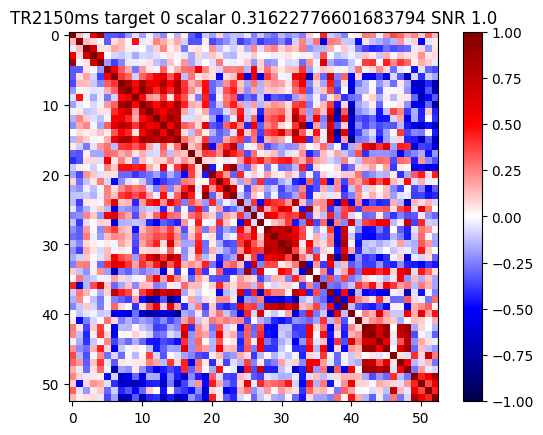

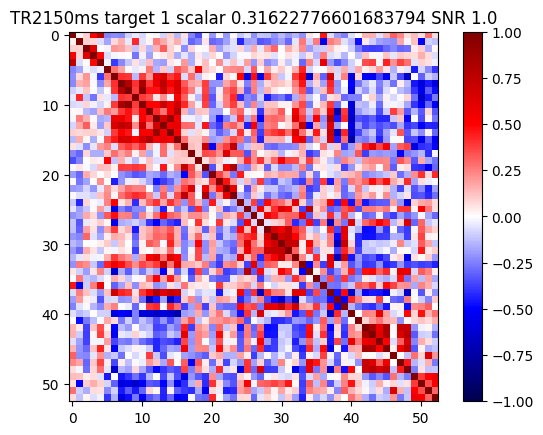

In [104]:
fnc_triu = tr2150_df.iloc[0]['TR2150ms_Window']
fncmat = np.zeros((53,53))
fncmat[np.triu_indices(53)] = fnc_triu
fncmat = fncmat + fncmat.T - np.diag(np.diag(fncmat))
plt.imshow(fncmat, cmap=plt.get_cmap('seismic'), vmin=-1, vmax=1)
plt.colorbar()
target = tr2150_df.iloc[0]['target']
plt.title(f'TR2150ms target {target} scalar {scalar} SNR {SNR}')
plt.show()

plt.clf()

fnc_triu = tr2150_df.iloc[1]['TR2150ms_Window']
fncmat = np.zeros((53,53))
fncmat[np.triu_indices(53)] = fnc_triu
fncmat = fncmat + fncmat.T - np.diag(np.diag(fncmat))
plt.imshow(fncmat, cmap=plt.get_cmap('seismic'), vmin=-1, vmax=1)
plt.colorbar()
target = tr2150_df.iloc[1]['target']
plt.title(f'TR2150ms target {target} scalar {scalar} SNR {SNR}')
plt.show()

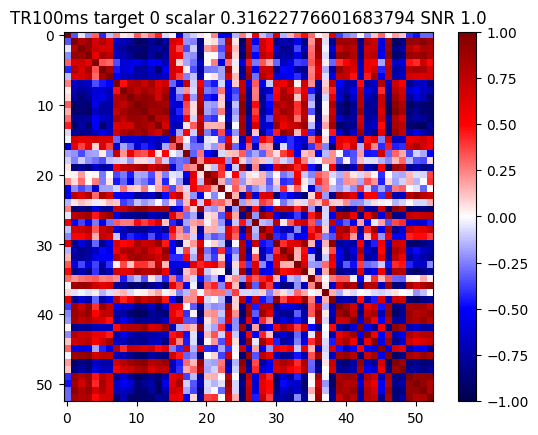

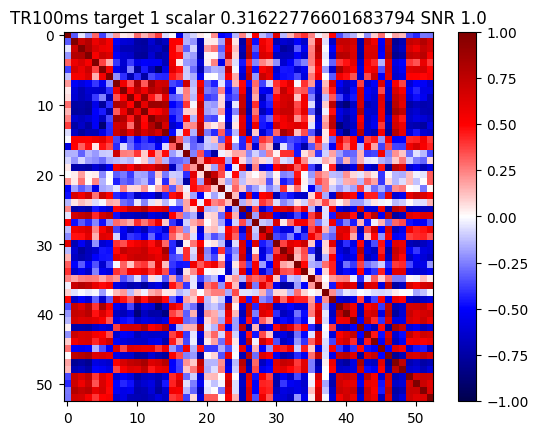

In [105]:
fnc_triu = tr100_df.iloc[0]['TR100ms_Window']
fncmat = np.zeros((53,53))
fncmat[np.triu_indices(53)] = fnc_triu
fncmat = fncmat + fncmat.T - np.diag(np.diag(fncmat))
plt.imshow(fncmat, cmap=plt.get_cmap('seismic'), vmin=-1, vmax=1)
plt.colorbar()
target = tr100_df.iloc[0]['target']
plt.title(f'TR100ms target {target} scalar {scalar} SNR {SNR}')
plt.show()

plt.clf()


fnc_triu = tr100_df.iloc[1]['TR100ms_Window']
fncmat = np.zeros((53,53))
fncmat[np.triu_indices(53)] = fnc_triu
fncmat = fncmat + fncmat.T - np.diag(np.diag(fncmat))
plt.imshow(fncmat, cmap=plt.get_cmap('seismic'), vmin=-1, vmax=1)
plt.colorbar()
target = tr100_df.iloc[1]['target']
plt.title(f'TR100ms target {target} scalar {scalar} SNR {SNR}')
plt.show()

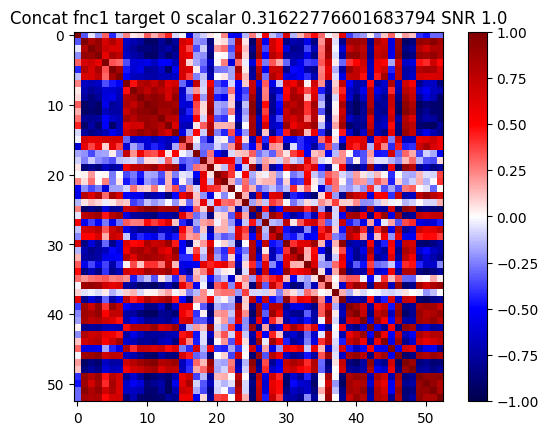

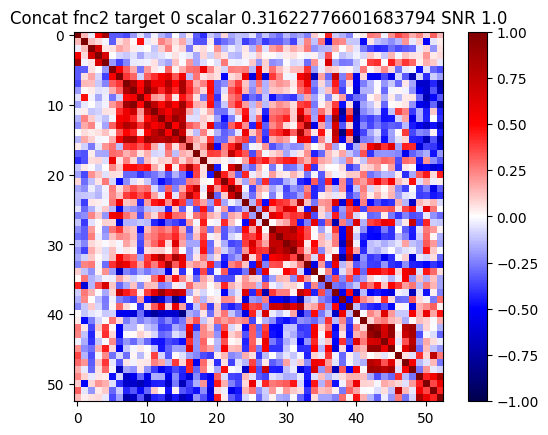

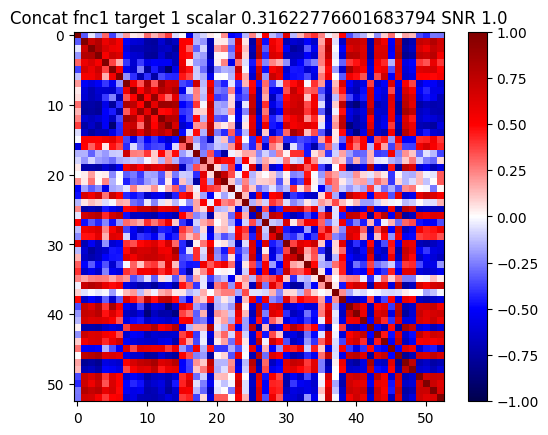

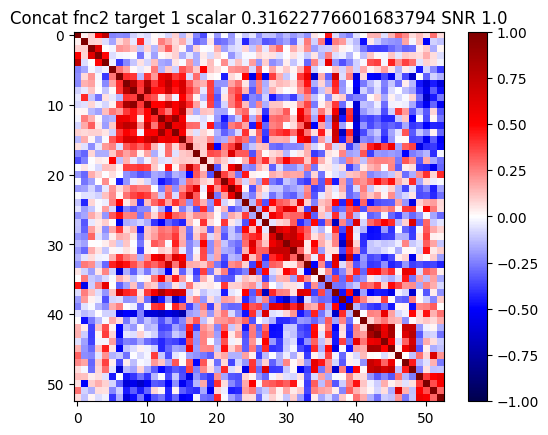

In [106]:
fnc_triu = concat_df.iloc[0]['Concat_Window']
fncmat1 = np.zeros((53,53))
fncmat2 = np.zeros((53,53))
fncmat1[np.triu_indices(53)] = fnc_triu[:1431]
fncmat2[np.triu_indices(53)] = fnc_triu[1431:]
fncmat1 = fncmat1 + fncmat1.T - np.diag(np.diag(fncmat1))
fncmat2 = fncmat2 + fncmat2.T - np.diag(np.diag(fncmat2))
plt.imshow(fncmat1, cmap=plt.get_cmap('seismic'), vmin=-1, vmax=1)
plt.colorbar()
target = concat_df.iloc[0]['target']
plt.title(f'Concat fnc1 target {target} scalar {scalar} SNR {SNR}')
plt.show()
plt.clf()

plt.imshow(fncmat2, cmap=plt.get_cmap('seismic'), vmin=-1, vmax=1)
plt.colorbar()
target = concat_df.iloc[0]['target']
plt.title(f'Concat fnc2 target {target} scalar {scalar} SNR {SNR}')
plt.show()
plt.clf()

fnc_triu = concat_df.iloc[1]['Concat_Window']
fncmat1 = np.zeros((53,53))
fncmat2 = np.zeros((53,53))
fncmat1[np.triu_indices(53)] = fnc_triu[:1431]
fncmat2[np.triu_indices(53)] = fnc_triu[1431:]
fncmat1 = fncmat1 + fncmat1.T - np.diag(np.diag(fncmat1))
fncmat2 = fncmat2 + fncmat2.T - np.diag(np.diag(fncmat2))
plt.imshow(fncmat1, cmap=plt.get_cmap('seismic'), vmin=-1, vmax=1)
plt.colorbar()
target = concat_df.iloc[1]['target']
plt.title(f'Concat fnc1 target {target} scalar {scalar} SNR {SNR}')
plt.show()
plt.clf()

plt.imshow(fncmat2, cmap=plt.get_cmap('seismic'), vmin=-1, vmax=1)
plt.colorbar()
target = concat_df.iloc[1]['target']
plt.title(f'Concat fnc2 target {target} scalar {scalar} SNR {SNR}')
plt.show()

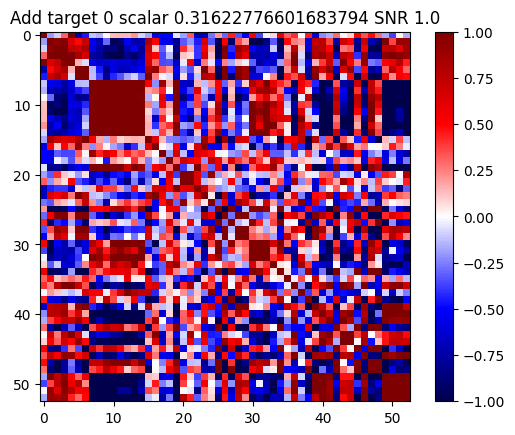

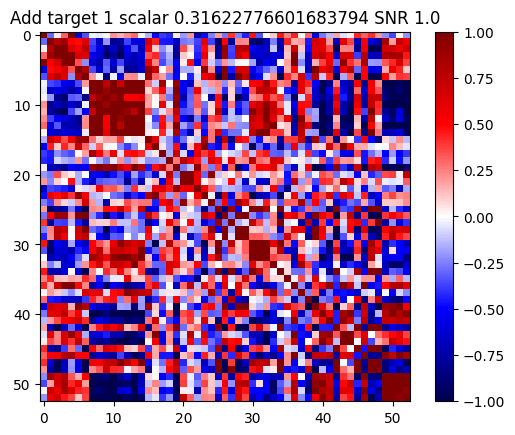

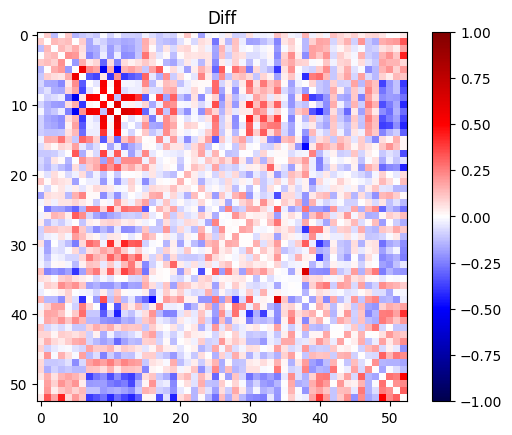

In [107]:
fnc_triu = add_df.iloc[0]['Add_Window']
fncmat1 = np.zeros((53,53))
fncmat1[np.triu_indices(53)] = fnc_triu
fncmat1 = fncmat1 + fncmat1.T - np.diag(np.diag(fncmat1))
plt.imshow(fncmat1, cmap=plt.get_cmap('seismic'), vmin=-1, vmax=1)
plt.colorbar()
target = add_df.iloc[0]['target']
plt.title(f'Add target {target} scalar {scalar} SNR {SNR}')
plt.show()
plt.clf()

fnc_triu = add_df.iloc[1]['Add_Window']
fncmat2 = np.zeros((53,53))
fncmat2[np.triu_indices(53)] = fnc_triu
fncmat2 = fncmat2 + fncmat2.T - np.diag(np.diag(fncmat2))
plt.imshow(fncmat2, cmap=plt.get_cmap('seismic'), vmin=-1, vmax=1)
plt.colorbar()
target = add_df.iloc[1]['target']
plt.title(f'Add target {target} scalar {scalar} SNR {SNR}')
plt.show()

plt.clf()
plt.imshow(fncmat1 - fncmat2, cmap=plt.get_cmap('seismic'), vmin=-1, vmax=1)
plt.colorbar()
target = add_df.iloc[1]['target']
plt.title('Diff')
plt.show()


2024-05-09 20:17:12,895 - INFO - 



 START POLYSSIFIER FOR TR=100ms snr 1.0 scalar 0.31622776601683794 noise_ix 0
2024-05-09 20:17:12,943 - INFO - Detected 2 classes in label
2024-05-09 20:17:12,944 - INFO - Building classifiers ...
2024-05-09 20:17:12,957 - INFO - Initialization, done.
2024-05-09 20:17:12,960 - INFO - Detected 10 unique groups


{0, 1, 2, 3, 4, 5, 6, 7, 8, 9}


2024-05-09 20:17:15,281 - INFO - Group Train: {1, 2, 3, 5, 6, 7, 8}
2024-05-09 20:17:15,304 - INFO - Training Multilayer Perceptron 0
2024-05-09 20:17:15,673 - INFO - Group Train: {0, 2, 3, 4, 6, 7, 8, 9}
2024-05-09 20:17:15,747 - INFO - Training Multilayer Perceptron 1
2024-05-09 20:17:16,417 - INFO - Group Train: {0, 1, 3, 4, 5, 7, 9}
2024-05-09 20:17:16,451 - INFO - Training Multilayer Perceptron 2
2024-05-09 20:17:16,459 - INFO - Group Train: {1, 2, 3, 5, 6, 7, 8}
2024-05-09 20:17:16,500 - INFO - Training SVM 0
2024-05-09 20:17:16,423 - INFO - Group Train: {0, 2, 3, 4, 6, 7, 8, 9}
2024-05-09 20:17:16,517 - INFO - Training SVM 1
2024-05-09 20:17:16,983 - INFO - Group Train: {0, 1, 2, 4, 5, 6, 8, 9}
2024-05-09 20:17:17,028 - INFO - Training Multilayer Perceptron 3
2024-05-09 20:17:17,212 - INFO - Group Train: {0, 1, 3, 4, 5, 7, 9}
2024-05-09 20:17:17,247 - INFO - Training SVM 2
2024-05-09 20:17:17,223 - INFO - Group Train: {0, 1, 2, 4, 5, 6, 8, 9}
2024-05-09 20:17:17,306 - INFO - Tra

                                 mean       std       min       max
Multilayer Perceptron train  1.000000  0.000000  1.000000  1.000000
                      test   0.736287  0.118286  0.610234  0.891476
SVM                   train  0.888249  0.154986  0.671257  1.000000
                      test   0.757347  0.016133  0.738594  0.770955
Logistic Regression   train  0.999853  0.000173  0.999666  1.000000
                      test   0.697015  0.072596  0.590538  0.745977
Naive Bayes           train  0.629606  0.087783  0.538438  0.746991
                      test   0.718345  0.033726  0.676007  0.750000
Voting                train  0.971484  0.048951  0.898214  1.000000
                      test   0.626042  0.113365  0.500000  0.750000


,graph_no,nstd,burnin,noise_no,snr,scalar,classifier,test_scores,target,predictions,test_proba
0,1002,1.0,100,0,1.0,0.316228,Logistic Regression,0 0.740295 1 0.71125 2 0.590538 3 ...,"[0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",0 0.999230 1 0.999929 2 0.99...
1,1002,1.0,100,0,1.0,0.316228,Multilayer Perceptron,0 0.891476 1 0.693633 2 0.610234 3 ...,"[0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",0 1.000000 1 1.000000 2 1.00...
2,1002,1.0,100,0,1.0,0.316228,Naive Bayes,0 0.706944 1 0.74043 2 0.676007 3 ...,"[0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0 5.453465e-300 1 7.212033e-189 2 ...
3,1002,1.0,100,0,1.0,0.316228,SVM,0 0.77066 1 0.738594 2 0.770955 3 ...,"[0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0 0.086553 1 0.093077 2 0.08...


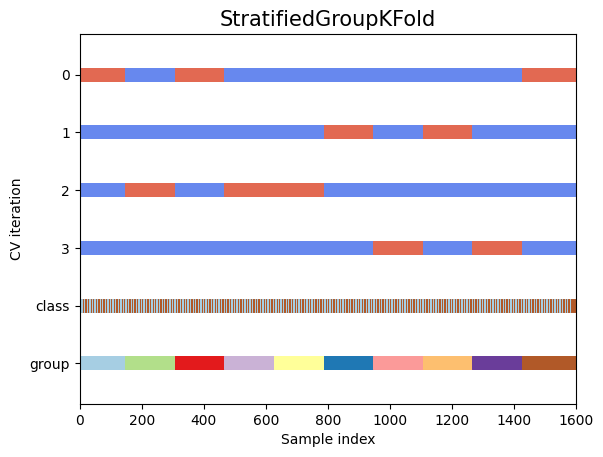

In [108]:
#############################
#   TR=100ms
#############################
logging.info(f'\n\n\n\n START POLYSSIFIER FOR TR=100ms snr {SNR} scalar {scalar} noise_ix {noise_ix}')
group_tr100 = tr100_df['subject']
y_tr100 = tr100_df['target']
y_tr100 = np.array([str(entry) for entry in y_tr100])
X_tr100 = tr100_df['TR100ms_Window']
X_tr100 = np.array([np.array(entry) for entry in X_tr100])

res1 = []
report1 = poly(data=X_tr100, label=y_tr100, groups=group_tr100, n_folds=n_folds, scale=True, concurrency=n_threads, save=False, 
                exclude=['Decision Tree', 'Random Forest', 'Voting', 'Nearest Neighbors', 'Linear SVM'],  scoring='auc')

for classifier in report1.scores.columns.levels[0]:
            if classifier == 'Voting':
                continue

            res1.append({'graph_no': graph_ix,
                            'nstd': nstd,
                            'burnin': burn,
                            'noise_no': noise_ix,
                            'snr': SNR,
                            'scalar': scalar,
                            'classifier': classifier,
                            'test_scores': report1.scores[classifier, 'test'], 
                            'target': report1.target, 
                            'predictions': np.array(report1.predictions[classifier]).astype(int),
                            'test_proba': report1.test_proba[classifier]})

            logging.info(report1.scores[classifier, 'test'])

df1 = pd.DataFrame(res1)  

df1.to_pickle(f'/data/users2/jwardell1/undersampling-project/OULU/pkl-files/sr1_{SNR}_{graph_ix}.pkl')      # write SR1 dataframe to disk as pickle

df1

2024-05-09 20:20:38,590 - INFO - 



 START POLYSSIFIER FOR TR=2150ms snr 1.0 scalar 0.31622776601683794 noise_ix 0
2024-05-09 20:20:38,621 - INFO - Detected 2 classes in label
2024-05-09 20:20:38,622 - INFO - Building classifiers ...
2024-05-09 20:20:38,631 - INFO - Initialization, done.
2024-05-09 20:20:38,634 - INFO - Detected 10 unique groups


{0, 1, 2, 3, 4, 5, 6, 7, 8, 9}


2024-05-09 20:20:40,521 - INFO - Group Train: {0, 2, 3, 4, 6, 7, 8, 9}
2024-05-09 20:20:40,525 - INFO - Training Multilayer Perceptron 1
2024-05-09 20:20:40,656 - INFO - Group Train: {1, 2, 3, 5, 6, 7, 8}
2024-05-09 20:20:40,677 - INFO - Training SVM 0
2024-05-09 20:20:40,842 - INFO - Group Train: {1, 2, 3, 5, 6, 7, 8}
2024-05-09 20:20:40,855 - INFO - Training Multilayer Perceptron 0
2024-05-09 20:20:41,022 - INFO - Group Train: {0, 1, 3, 4, 5, 7, 9}
2024-05-09 20:20:41,043 - INFO - Training Multilayer Perceptron 2
2024-05-09 20:20:41,240 - INFO - Group Train: {0, 1, 2, 4, 5, 6, 8, 9}
2024-05-09 20:20:41,262 - INFO - Training Multilayer Perceptron 3
2024-05-09 20:20:41,239 - INFO - Group Train: {0, 2, 3, 4, 6, 7, 8, 9}
2024-05-09 20:20:41,297 - INFO - Training SVM 1
2024-05-09 20:20:42,087 - INFO - Group Train: {0, 1, 2, 4, 5, 6, 8, 9}
2024-05-09 20:20:42,125 - INFO - Training SVM 3
2024-05-09 20:20:42,463 - INFO - Group Train: {0, 1, 3, 4, 5, 7, 9}
2024-05-09 20:20:42,493 - INFO - Tra

                                 mean       std       min       max
Multilayer Perceptron train  1.000000  0.000000  1.000000  1.000000
                      test   0.844842  0.102232  0.724080  0.959023
SVM                   train  1.000000  0.000000  1.000000  1.000000
                      test   0.866184  0.097490  0.758086  0.981719
Logistic Regression   train  1.000000  0.000000  1.000000  1.000000
                      test   0.883222  0.094172  0.777986  0.998789
Naive Bayes           train  0.868448  0.024857  0.837366  0.897430
                      test   0.850706  0.105342  0.741875  0.956211
Voting                train  1.000000  0.000000  1.000000  1.000000
                      test   0.809635  0.091798  0.721875  0.937500


,graph_no,nstd,burnin,noise_no,snr,scalar,classifier,test_scores,target,predictions,test_proba
0,1002,1.0,100,0,1.0,0.316228,Logistic Regression,0 0.777986 1 0.998789 2 0.845486 3 ...,"[0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, ...","[0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, ...",0 0.191213 1 0.998468 2 0.15...
1,1002,1.0,100,0,1.0,0.316228,Multilayer Perceptron,0 0.72408 1 0.959023 2 0.805052 3 ...,"[0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",0 0.942167 1 0.999603 2 0.91...
2,1002,1.0,100,0,1.0,0.316228,Naive Bayes,0 0.924167 1 0.956211 2 0.780573 3 ...,"[0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0 7.359253e-27 1 3.562305e-01 2 ...
3,1002,1.0,100,0,1.0,0.316228,SVM,0 0.90401 1 0.981719 2 0.82092 3 ...,"[0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0 0.005390 1 0.223374 2 0.00...


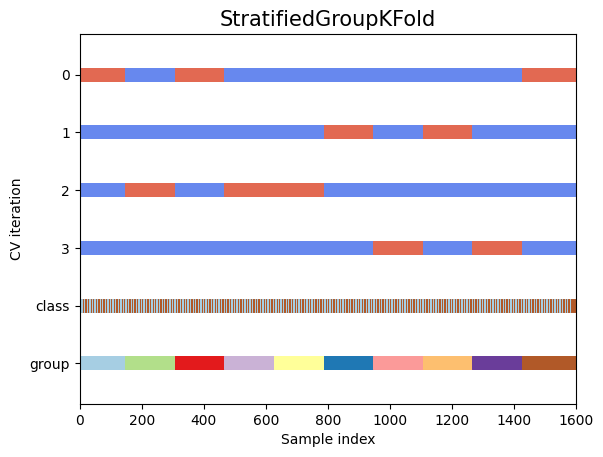

In [109]:
#############################
#   TR=2150ms
#############################
logging.info(f'\n\n\n\n START POLYSSIFIER FOR TR=2150ms snr {SNR} scalar {scalar} noise_ix {noise_ix}')
group_tr2150 = tr2150_df['subject']
y_tr2150 = tr2150_df['target']
y_tr2150 = np.array([str(entry) for entry in y_tr2150])
X_tr2150 = tr2150_df['TR2150ms_Window']
X_tr2150 = np.array([np.array(entry) for entry in X_tr2150])

res2 = []
report2 = poly(data=X_tr2150, label=y_tr2150, groups=group_tr2150, n_folds=n_folds, scale=True, concurrency=n_threads, save=False, 
                exclude=['Decision Tree', 'Random Forest', 'Voting', 'Nearest Neighbors', 'Linear SVM'],  scoring='auc')

for classifier in report2.scores.columns.levels[0]:                                                                                         # iterate through all classifiers in the report
            if classifier == 'Voting':
                continue

            res2.append({'graph_no': graph_ix,                                                                                                      # save the SR1 results to a dict for results dataframe
                            'nstd': nstd,
                            'burnin': burn,
                            'noise_no': noise_ix,
                            'snr': SNR,
                            'scalar': scalar,
                            'classifier': classifier,
                            'test_scores': report2.scores[classifier, 'test'], 
                            'target': report2.target, 
                            'predictions': np.array(report2.predictions[classifier]).astype(int),
                            'test_proba': report2.test_proba[classifier]})

            logging.info(report2.scores[classifier, 'test'])


df2 = pd.DataFrame(res2)

df2.to_pickle(f'/data/users2/jwardell1/undersampling-project/OULU/pkl-files/sr2_{SNR}_{graph_ix}.pkl')      # write SR2 dataframe to disk as pickle

df2



2024-05-09 20:22:45,347 - INFO - 



 START POLYSSIFIER FOR CONCAT snr 1.0 scalar 0.31622776601683794 noise_ix 0
2024-05-09 20:22:45,381 - INFO - Detected 2 classes in label
2024-05-09 20:22:45,382 - INFO - Building classifiers ...
2024-05-09 20:22:45,388 - INFO - Initialization, done.
2024-05-09 20:22:45,390 - INFO - Detected 10 unique groups


{0, 1, 2, 3, 4, 5, 6, 7, 8, 9}


2024-05-09 20:22:47,718 - INFO - Group Train: {0, 2, 3, 4, 6, 7, 8, 9}
2024-05-09 20:22:47,722 - INFO - Training Multilayer Perceptron 1
2024-05-09 20:22:48,525 - INFO - Group Train: {1, 2, 3, 5, 6, 7, 8}
2024-05-09 20:22:48,568 - INFO - Training Multilayer Perceptron 0
2024-05-09 20:22:49,817 - INFO - Group Train: {0, 1, 3, 4, 5, 7, 9}
2024-05-09 20:22:49,835 - INFO - Training Multilayer Perceptron 2
2024-05-09 20:22:51,214 - INFO - Group Train: {0, 1, 2, 4, 5, 6, 8, 9}
2024-05-09 20:22:51,246 - INFO - Training Multilayer Perceptron 3
2024-05-09 20:22:51,797 - INFO - Group Train: {1, 2, 3, 5, 6, 7, 8}
2024-05-09 20:22:51,826 - INFO - Training SVM 0
2024-05-09 20:22:51,911 - INFO - Group Train: {0, 1, 2, 4, 5, 6, 8, 9}
2024-05-09 20:22:51,945 - INFO - Training SVM 3
2024-05-09 20:22:51,889 - INFO - Group Train: {0, 2, 3, 4, 6, 7, 8, 9}
2024-05-09 20:22:51,991 - INFO - Training SVM 1
2024-05-09 20:22:51,997 - INFO - Group Train: {0, 1, 3, 4, 5, 7, 9}
2024-05-09 20:22:52,031 - INFO - Tra

                                 mean       std       min       max
Multilayer Perceptron train  1.000000  0.000000  1.000000  1.000000
                      test   0.794388  0.087446  0.686806  0.898403
SVM                   train  1.000000  0.000000  1.000000  1.000000
                      test   0.771468  0.059456  0.709219  0.850508
Logistic Regression   train  1.000000  0.000000  1.000000  1.000000
                      test   0.861469  0.140910  0.698767  1.000000
Naive Bayes           train  0.678965  0.080449  0.615128  0.796347
                      test   0.743124  0.070822  0.643993  0.806523
Voting                train  1.000000  0.000000  1.000000  1.000000
                      test   0.696875  0.057741  0.627083  0.746875


,graph_no,nstd,burnin,noise_no,snr,scalar,classifier,test_scores,target,predictions,test_proba
0,1002,1.0,100,0,1.0,0.316228,Logistic Regression,0 1.0 1 0.791055 2 0.698767 3 ...,"[0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",0 1.000000 1 1.000000 2 1.00...
1,1002,1.0,100,0,1.0,0.316228,Multilayer Perceptron,0 0.898403 1 0.812617 2 0.686806 3 ...,"[0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",0 0.999958 1 1.000000 2 0.99...
2,1002,1.0,100,0,1.0,0.316228,Naive Bayes,0 0.77776 1 0.744219 2 0.643993 3 ...,"[0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0 0.000000e+00 1 3.990786e-189 2 ...
3,1002,1.0,100,0,1.0,0.316228,SVM,0 0.776146 1 0.75 2 0.709219 3 ...,"[0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0 0.000009 1 0.000076 2 0.00...


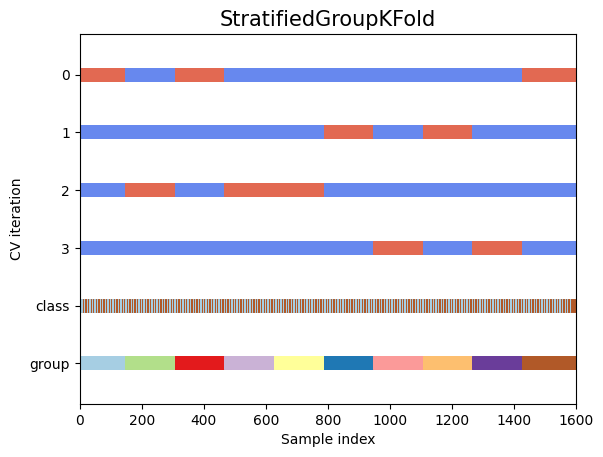

In [110]:

#############################
#   CONCAT
#############################
logging.info(f'\n\n\n\n START POLYSSIFIER FOR CONCAT snr {SNR} scalar {scalar} noise_ix {noise_ix}')
group_concat = concat_df['subject']
y_concat = concat_df['target']
y_concat = np.array([str(entry) for entry in y_concat])
X_concat = concat_df['Concat_Window']
X_concat = np.array([np.array(entry) for entry in X_concat])

res3 = []
report3 = poly(data=X_concat, label=y_concat, groups=group_concat, n_folds=n_folds, scale=True, concurrency=n_threads, save=False, 
                exclude=['Decision Tree', 'Random Forest', 'Voting', 'Nearest Neighbors', 'Linear SVM'],  scoring='auc')

for classifier in report3.scores.columns.levels[0]:                                                                                         # iterate through all classifiers in the report
            if classifier == 'Voting':
                continue

            res3.append({'graph_no': graph_ix,                                                                                                      # save the SR1 results to a dict for results dataframe
                            'nstd': nstd,
                            'burnin': burn,
                            'noise_no': noise_ix,
                            'snr': SNR,
                            'scalar': scalar,
                            'classifier': classifier,
                            'test_scores': report3.scores[classifier, 'test'], 
                            'target': report3.target, 
                            'predictions': np.array(report3.predictions[classifier]).astype(int),
                            'test_proba': report3.test_proba[classifier]})

            logging.info(report3.scores[classifier, 'test'])


df3 = pd.DataFrame(res3)                                                                                    # save CONCAT results as dataframe

df3.to_pickle(f'/data/users2/jwardell1/undersampling-project/OULU/pkl-files/concat_{SNR}_{graph_ix}.pkl')   # write CONCAT dataframe to disk as pickle

df3



2024-05-09 20:26:54,145 - INFO - 



 START POLYSSIFIER FOR ADD snr 1.0 scalar 0.31622776601683794 noise_ix 0
2024-05-09 20:26:54,164 - INFO - Detected 2 classes in label
2024-05-09 20:26:54,166 - INFO - Building classifiers ...
2024-05-09 20:26:54,173 - INFO - Initialization, done.
2024-05-09 20:26:54,174 - INFO - Detected 10 unique groups


{0, 1, 2, 3, 4, 5, 6, 7, 8, 9}


2024-05-09 20:26:56,111 - INFO - Group Train: {0, 1, 3, 4, 5, 7, 9}
2024-05-09 20:26:56,115 - INFO - Training Multilayer Perceptron 2
2024-05-09 20:26:56,321 - INFO - Group Train: {1, 2, 3, 5, 6, 7, 8}
2024-05-09 20:26:56,353 - INFO - Group Train: {1, 2, 3, 5, 6, 7, 8}
2024-05-09 20:26:56,345 - INFO - Training SVM 0
2024-05-09 20:26:56,370 - INFO - Training Multilayer Perceptron 0
2024-05-09 20:26:56,443 - INFO - Group Train: {0, 2, 3, 4, 6, 7, 8, 9}
2024-05-09 20:26:56,457 - INFO - Training Multilayer Perceptron 1
2024-05-09 20:26:56,454 - INFO - Group Train: {0, 1, 2, 4, 5, 6, 8, 9}
2024-05-09 20:26:56,467 - INFO - Training Multilayer Perceptron 3
2024-05-09 20:26:56,744 - INFO - Group Train: {0, 1, 3, 4, 5, 7, 9}
2024-05-09 20:26:56,767 - INFO - Training SVM 2
2024-05-09 20:26:57,276 - INFO - Group Train: {0, 2, 3, 4, 6, 7, 8, 9}
2024-05-09 20:26:57,335 - INFO - Training SVM 1
2024-05-09 20:26:57,472 - INFO - Group Train: {0, 2, 3, 4, 6, 7, 8, 9}
2024-05-09 20:26:57,494 - INFO - Tra

KeyboardInterrupt: 

2024-05-09 20:27:06,181 - INFO - Group Test: {1, 5}
2024-05-09 20:27:06,206 - INFO - Group Test: {0, 9, 4}
2024-05-09 20:27:06,397 - INFO - Logistic Regression        1: Train 1.00/Test 0.74, 8.90 sec
2024-05-09 20:27:06,409 - INFO - Group Test: {8, 2, 6}
2024-05-09 20:27:06,515 - INFO - Logistic Regression        0: Train 1.00/Test 0.96, 8.83 sec
2024-05-09 20:27:06,780 - INFO - Logistic Regression        2: Train 1.00/Test 0.72, 8.93 sec


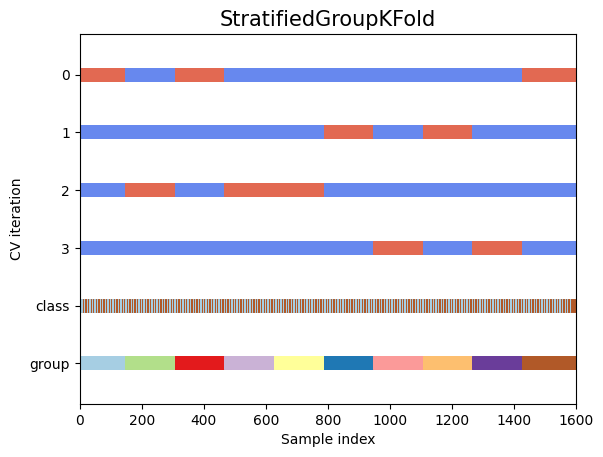

2024-05-09 20:27:06,963 - INFO - Group Test: {3, 7}
2024-05-09 20:27:07,152 - INFO - Logistic Regression        3: Train 1.00/Test 0.75, 9.43 sec
2024-05-09 20:27:07,558 - INFO - Group Train: {1, 2, 3, 5, 6, 7, 8}
2024-05-09 20:27:07,589 - INFO - Training Naive Bayes 0
2024-05-09 20:27:07,658 - INFO - Group Train: {0, 2, 3, 4, 6, 7, 8, 9}
2024-05-09 20:27:07,677 - INFO - Training Naive Bayes 1
2024-05-09 20:27:07,857 - INFO - Group Train: {0, 1, 3, 4, 5, 7, 9}
2024-05-09 20:27:07,898 - INFO - Training Naive Bayes 2
2024-05-09 20:27:08,028 - INFO - Group Train: {0, 1, 2, 4, 5, 6, 8, 9}
2024-05-09 20:27:08,054 - INFO - Training Naive Bayes 3
2024-05-09 20:27:08,787 - INFO - Group Test: {0, 9, 4}
2024-05-09 20:27:08,979 - INFO - Group Test: {8, 2, 6}
2024-05-09 20:27:08,984 - INFO - Group Test: {1, 5}
2024-05-09 20:27:09,056 - INFO - Group Test: {3, 7}
2024-05-09 20:27:09,092 - INFO - Naive Bayes                0: Train 0.82/Test 0.77, 1.50 sec
2024-05-09 20:27:09,183 - INFO - Naive Bayes

In [111]:
#############################
#   ADD
#############################
logging.info(f'\n\n\n\n START POLYSSIFIER FOR ADD snr {SNR} scalar {scalar} noise_ix {noise_ix}')
group_add = add_df['subject']
y_add = add_df['target']
y_add = np.array([str(entry) for entry in y_add])
X_add = add_df['Add_Window']
X_add = np.array([np.array(entry) for entry in X_add])

res4 = []
report4 = poly(data=X_add, label=y_add, groups=group_add, n_folds=n_folds, scale=True, concurrency=n_threads, save=False, 
                exclude=['Decision Tree', 'Random Forest', 'Voting', 'Nearest Neighbors', 'Linear SVM'],  scoring='auc')

for classifier in report4.scores.columns.levels[0]:                                                                                         # iterate through all classifiers in the report
            if classifier == 'Voting':
                continue

            res4.append({'graph_no': graph_ix,                                                                                                      # save the SR1 results to a dict for results dataframe
                            'nstd': nstd,
                            'burnin': burn,
                            'noise_no': noise_ix,
                            'snr': SNR,
                            'scalar': scalar,
                            'classifier': classifier,
                            'test_scores': report4.scores[classifier, 'test'], 
                            'target': report4.target, 
                            'predictions': np.array(report4.predictions[classifier]).astype(int),
                            'test_proba': report4.test_proba[classifier]})

            logging.info(report4.scores[classifier, 'test'])



df4 = pd.DataFrame(res4)                                                                                    # save ADD results as dataframe

df4.to_pickle(f'/data/users2/jwardell1/undersampling-project/OULU/pkl-files/add_{SNR}_{graph_ix}.pkl')      # write ADD dataframe to disk as pickle

df4

2024-05-09 21:19:27,285 - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2024-05-09 21:19:27,300 - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


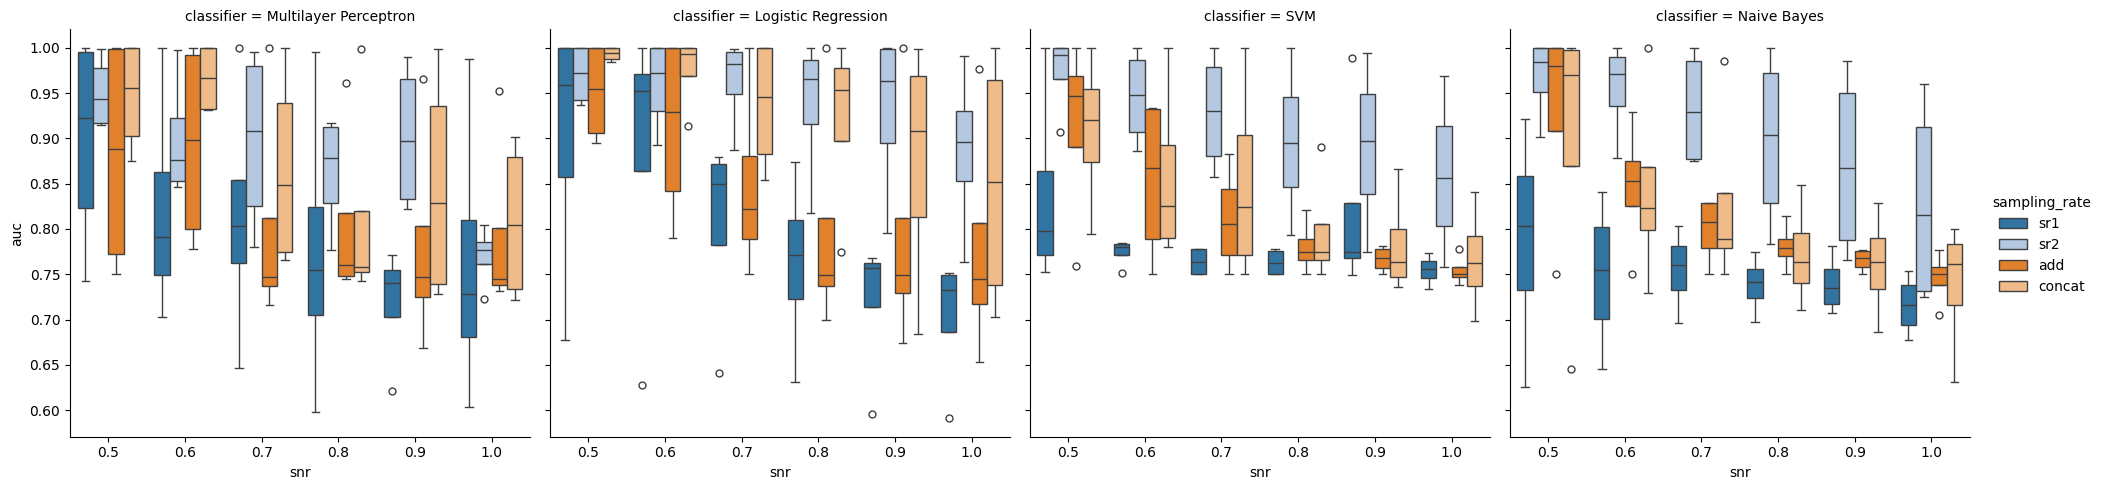

In [125]:
import pandas as pd
import os
import glob
import matplotlib.ticker as ticker # type: ignore
from statannot import add_stat_annotation


import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns

import numpy as np
import os
from matplotlib.ticker import MaxNLocator

from sklearn.metrics import roc_curve, auc

import os
import glob
import pandas as pd

#pkl_dir = '/data/users2/jwardell1/undersampling-project/HCP/pkl-files'
pkl_dir = '/data/users2/jwardell1/undersampling-project/OULU/pkl-files'

# Read and concatenate sr1 data
joined_files = os.path.join(pkl_dir, 'sr1_*.pkl')
joined_list = glob.glob(joined_files)
sr1 = pd.concat((pd.read_pickle(file).assign(sampling_rate='sr1') for file in joined_list), ignore_index=True)

# Read and concatenate sr2 data
joined_files = os.path.join(pkl_dir, 'sr2_*.pkl')
joined_list = glob.glob(joined_files)
sr2 = pd.concat((pd.read_pickle(file).assign(sampling_rate='sr2') for file in joined_list), ignore_index=True)

# Read and concatenate concat data
joined_files = os.path.join(pkl_dir, 'concat_*.pkl')
joined_list = glob.glob(joined_files)
concat = pd.concat((pd.read_pickle(file).assign(sampling_rate='concat') for file in joined_list), ignore_index=True)

# Read and concatenate add data
joined_files = os.path.join(pkl_dir, 'add_*.pkl')
joined_list = glob.glob(joined_files)
add = pd.concat((pd.read_pickle(file).assign(sampling_rate='add') for file in joined_list), ignore_index=True)

# Concatenate all dataframes
all_data = pd.concat([sr1, sr2, concat, add], ignore_index=True)

import pandas as pd

# Function to split each row into multiple rows based on cross-validation index
def split_row(row):
    new_rows = []
    for cv_ix, auc in enumerate(row['test_scores']):
        new_row = row.copy()
        new_row['auc'] = auc
        new_row['cv_ix'] = cv_ix
        new_rows.append(new_row)
    return pd.DataFrame(new_rows)

# Apply the split_row function to each row of the dataframe and concatenate the results
result_df = pd.concat(all_data.apply(split_row, axis=1).tolist(), ignore_index=True)



# Drop the original 'test_scores' column as it's no longer needed
result_df.drop('test_scores', axis=1, inplace=True)



grouped_classifiers = result_df.groupby('classifier')


classifier_dfs = {}
for classifier, group_df in grouped_classifiers:
    classifier_dfs[classifier] = group_df.copy()

mlp_df = classifier_dfs['Multilayer Perceptron']
lr_df = classifier_dfs['Logistic Regression']
svm_df = classifier_dfs['SVM']
nb_df = classifier_dfs['Naive Bayes']

import seaborn as sns
import matplotlib.pyplot as plt


dfs = [mlp_df, lr_df, svm_df, nb_df]


snr_levels = [0.5, 0.6, 0.7, 0.8, 0.9, 1.0]



classifiers = ['Multilayer Perceptron', 'Logistic Regression', 'SVM', 'Naive Bayes']
sampling_rates = ['sr1', 'sr2', 'add', 'concat']
hue_order = sampling_rates
palette = { item: plt.cm.tab20(i) for i, item in enumerate(sampling_rates)}

# Combine all dataframes into one dataframe for plotting
combined_df = pd.concat(dfs)

# Plot all boxplots in one plot using catplot
ax = sns.catplot(
    x="snr", 
    order=snr_levels,
    y="auc",
    hue="sampling_rate",
    hue_order=hue_order,
    col="classifier",
    data=combined_df,
    kind="box",
    palette=palette,
    showfliers=True,
)




#plt.savefig('all_oulu_5-2.png')
#plt.savefig('all_hcp_5-2.png')

